# Calculating Extreme Heat days using daily projections from Cal-Adapt API

This notebook walks you through how to make API requests of projected Extreme Heat Days for an area.

### Step 1. Request data
 - Request extreme heat events for the location. We will use the 4 priority models and RCP 8.5 scenario (HadGEM2-ES, CNRM-CM5, CanESM2, MIROC5 models have been selected by [California’s Climate Action Team Research Working Group](http://climatechange.ca.gov/climate_action_team/research.html) as [priority models for research](http://docketpublic.energy.ca.gov/PublicDocuments/16-IEPR-04/TN215798_20170207T111409_Projected_Climate_Scenarios_Selected_to_Represent_a_Range_of_Po.pdf) contributing to California’s Fourth Climate Change Assessment).
 
### Step 2. Report projected extreme heat days
 - For reporting projected Extreme Heat day counts we reccommend using decadal or multi-decadal averages for future time periods.
 - The 98th percentile value is the Extreme Heat Threshold for the location (note: different locations will have different values for extreme heat threshold).
 
### Step 3. Request and report heat waves

In [125]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

----
## Step 1. Request data
----

### 1a. Defining your area of interest

The `g` geometry parameter is used to request data for a point, line or polygon. Geometry can be written in various formats including WKT, GeoJSON, KML. The examples below use WKT (Well Known Text) format.

#### To get data for a grid cell ...

In [2]:
point = 'POINT(-121.4687 38.5938)'
params = {'g': point}

#### To get data for a user defined polygon ...

The `stat` parameter is used to spatially aggregation grid cell values intersected by the polygon/line geometry. Accepted values can be one of `mean`, `max`, `min`, `count`, `median`, `std`, `var`. If you don't provide the `stat` parameter the API will return an array of grid cell values.

You can create a new polygon using this [online WKT editor](https://arthur-e.github.io/Wicket/sandbox-gmaps3.html) or any GIS software.

In [3]:
polygon = 'POLYGON ((-123.35449 39.09596, -122.27783 39.09596, -122.27783 39.97712, -123.35449 39.97712, -123.35449 39.09596))' 
params = {'g': polygon, 'stat': 'mean'}

#### Or select a polygon from boundaries stored on Cal-Adapt

To use polygon geometry from Cal-Adapt API, it's a 2-step process

- Query a Cal-Adapt API boundary layer ([list of available boundaries](https://berkeley-gif.github.io/caladapt-docs/data-catalog.html#vector-data)) using a point to get the intersecting polygon
- Instead of passing the geometry using the `g` parameter, use the `ref` parameter to use geometry stored on server 

**Note: Requests might time out if the polygon is too large. If you need to spatially aggregate daily data for extreme heat calculations, the data provider reccomends doing that at a scale of census tracts, city boundaries or small watershed boundaries (e.g. HUC10). If you need to process data for several boundaries we reccomend requesting the daily rasters and processing the data locally.** 

In [160]:
# Cal-Adapt API
api = 'https://api.cal-adapt.org/api'
headers = {'ContentType': 'json'}

# Your point of interest
point = 'POINT(-121.4687 38.5938)'

# Name of boundary layer in API (Census Tracts)
resource = 'censustracts'

# Request url
url = '%s/%s/' % (api, resource)
# Request params to find intersecting polygon
params = {'intersects': point, 'srs': 4326, 'simplify': .0001, 'precision': 4}

# Get geometry
response = requests.get(url, params=params, headers=headers)
if response.ok:
    data = response.json()
    feature = data['features'][0]
    if feature:
        ref = '/api/%s/%s/' % (resource, feature['id'])
        params = {'ref': ref, 'stat': 'mean'}
        print('ref:', ref)
        location = 'census tract ID %s' % feature['properties']['tract']
        print('location:', location)
    else:
        print('Did not find any polygons that intersect your point')

ref: /api/censustracts/5074/
location: census tract ID 6067006900


### 1b. Request number of extreme heat events per year

In [159]:
baseurl = 'https://api.cal-adapt.org/api/series/%s/exheat/'

def fetch_exheat(*urlargs, **params):
    items = itertools.product(*urlargs)
    series = []
    for parts in items:
        slug = '_'.join(parts)
        print('Processing:', slug)
        response = requests.get(baseurl % slug, params)
        data = response.json()
        counts = pd.Series(data['counts']).sort_index()
        counts.index = pd.to_datetime(counts.index).tz_localize(None)
        counts.name = slug
        series.append(counts)
    return pd.concat(series, axis=1)

In [131]:
climvar = ['tasmax']
period = ['day']
models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5']
scenarios = ['rcp45']
hmodelcounts = fetch_exheat(climvar, period, models, ['historical'], **params)
hmodelcounts.columns = hmodelcounts.columns.str.replace('tasmax_day_', '')
projcounts = fetch_exheat(climvar, period, models, scenarios, **params)
projcounts.columns = projcounts.columns.str.replace('tasmax_day_', '')
projcounts = projcounts.append(hmodelcounts).sort_index()
projcounts.head()

Processing: tasmax_day_CanESM2_historical
Processing: tasmax_day_CNRM-CM5_historical
Processing: tasmax_day_HadGEM2-ES_historical
Processing: tasmax_day_MIROC5_historical
Processing: tasmax_day_CanESM2_rcp45
Processing: tasmax_day_CNRM-CM5_rcp45
Processing: tasmax_day_HadGEM2-ES_rcp45
Processing: tasmax_day_MIROC5_rcp45


,CNRM-CM5_historical,CNRM-CM5_rcp45,CanESM2_historical,CanESM2_rcp45,HadGEM2-ES_historical,HadGEM2-ES_rcp45,MIROC5_historical,MIROC5_rcp45
1950-12-31,3.0,NaN,2.0,NaN,2.0,NaN,3.0,NaN
1951-12-31,3.0,NaN,6.0,NaN,5.0,NaN,10.0,NaN
1952-12-31,3.0,NaN,3.0,NaN,2.0,NaN,3.0,NaN
1953-12-31,5.0,NaN,4.0,NaN,10.0,NaN,3.0,NaN
1954-12-31,5.0,NaN,4.0,NaN,2.0,NaN,13.0,NaN


----
## Step 2.  Report projected Extreme heat days
----

For the Cal-Adapt Extreme Heat Tool, default Extreme Heat Threshold is the 98th percentile of historical maximum temperatures between April 1 and October 31 based on observed daily temperature data from 1961–1990. If you want to use a different cutoff temperature you can skip this step.

### 2a. Number of extreme heat days by year from observed data, averaged over 1961-1990

In [132]:
obsurl = 'https://api.cal-adapt.org/api/series/tasmax_day_livneh/exheat/'
response = requests.get(obsurl, params)
data = response.json()
hcounts = pd.Series(data['counts']).sort_index()
hcounts.index = pd.to_datetime(hcounts.index).tz_convert(None)
hmean = hcounts['1961':'1990'].mean()
print('Historically (1961-1990) {} had an average of {} days with daily highs above {} degrees F'.format(location, int(hmean), round(data['98p'], 1)))

Historically (1961-1990) census tract ID 6067006900 had an average of 4 days with daily highs above 104.0 degrees F


### 2b. Number of extreme heat days by year from HadGEM2-ES RCP 4.5, averaged over 2070-2099

In [133]:
url = 'https://api.cal-adapt.org/api/series/tasmax_day_HadGEM2-ES_rcp45/exheat/'
response = requests.get(url, params)
data = response.json()
counts = pd.Series(data['counts']).sort_index()
counts.index = pd.to_datetime(counts.index).tz_convert(None)
mean = counts['2070':'2099'].mean()
msg = ('If current emission trends peak around 2040 and then decline (RCP 4.5) ' 
       '{} will have an average of {} days with daily highs above {} degrees F '
       'by end of century (2070-2099) under simulated warmer/drier conditions (HadGEM2-ES)')
print(msg.format(location, int(mean), round(data['98p'], 1)))

If current emission trends peak around 2040 and then decline (RCP 4.5) census tract ID 6067006900 will have an average of 28 days with daily highs above 40.0 degrees F by end of century (2070-2099) under simulated warmer/drier conditions (HadGEM2-ES)


### 2c. Plot Number of Extreme Heat Days by Year

Text(0, 0.5, 'Number of Extreme Heat Days by Year')

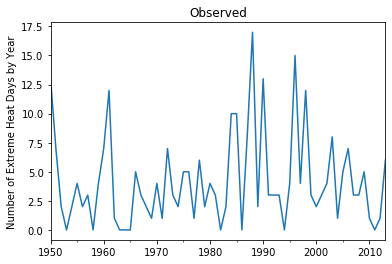

In [134]:
hcounts.plot()
plt.title('Observed')
plt.ylabel('Number of Extreme Heat Days by Year')

Text(0, 0.5, 'Number of Extreme Heat Days by Year')

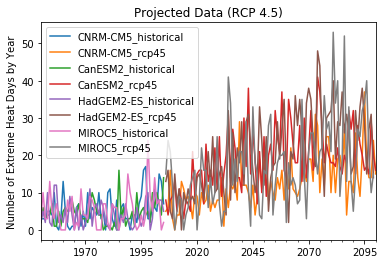

In [135]:
projcounts.plot()
plt.title('Projected Data (RCP 4.5)')
plt.ylabel('Number of Extreme Heat Days by Year')

### 2d. Heatmap of Timing of Extreme Heat Days

In [161]:
params.update(freq='M')
response = requests.get(obsurl, params)
data = response.json()
hmcounts = pd.Series(data['counts']).sort_index()
hmcounts.index = pd.to_datetime(hmcounts.index).tz_convert(None)

In [177]:
hmatrix = hmcounts.groupby([hmcounts.index.year, hmcounts.index.month]).sum()
hmatrix = hmatrix.unstack(0).fillna(0).sort_index(ascending=False)
hmatrix

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
7,2.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,4.0,6.0,2.0,2.0,3.0,0.0,0.0,0.0,3.0
6,2.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


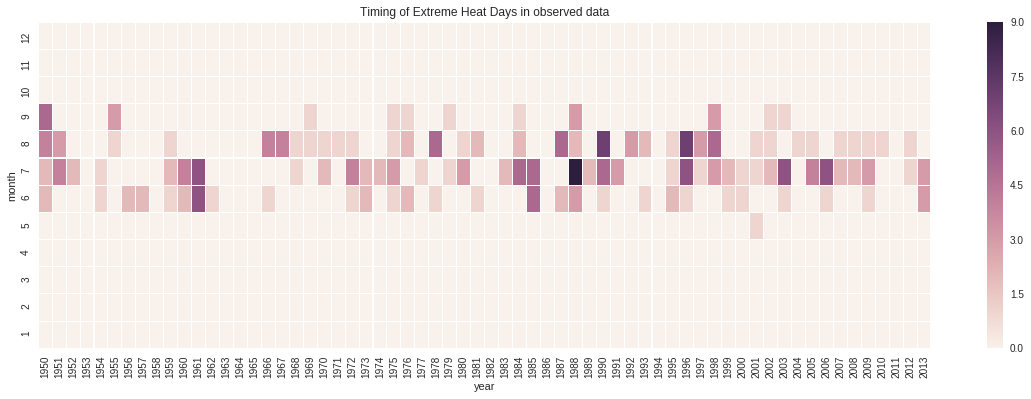

In [45]:
plt.figure(figsize=(20,6))
ax = sns.heatmap(hmatrix, linewidth=0.1)
plt.title('Timing of Extreme Heat Days in observed data')
plt.show()

In [171]:
url = 'https://api.cal-adapt.org/api/series/tasmax_day_CNRM-CM5_rcp45/exheat/'
response = requests.get(url, params)
data = response.json()
coolwet = pd.Series(data['counts']).sort_index()
coolwet.index = pd.to_datetime(coolwet.index).tz_localize(None)
coolwet_m = coolwet.groupby([coolwet.index.year, coolwet.index.month]).sum()
coolwet_m = coolwet_m.unstack(0).fillna(0).sort_index(ascending=False)

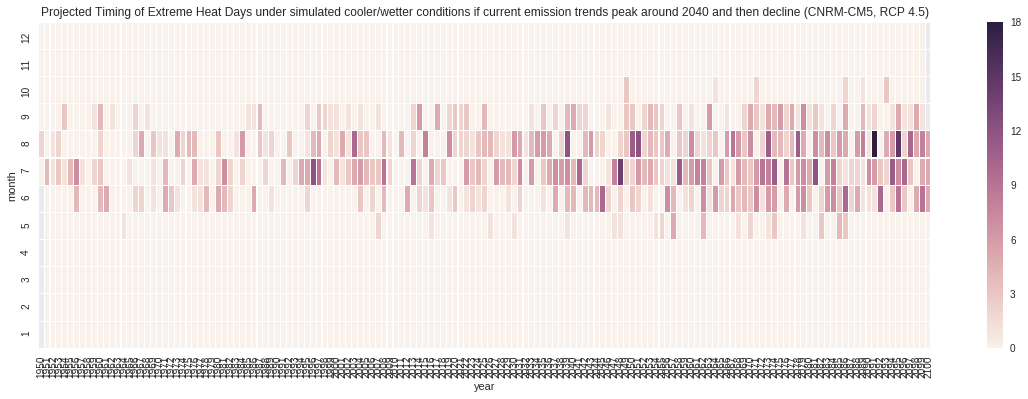

In [48]:
plt.figure(figsize=(20,6))
ax = sns.heatmap(coolwet_m, linewidth=0.1)
plt.title("Projected Timing of Extreme Heat Days under simulated cooler/wetter conditions if current emission trends peak around 2040 and then decline (CNRM-CM5, RCP 4.5)")
plt.show()

In [ ]:
url = 'https://api.cal-adapt.org/api/series/tasmax_day_HadGEM2-ES_rcp45/exheat/'
response = requests.get(url, params)
data = response.json()
hotdry = pd.Series(data['counts']).sort_index()
hotdry.index = pd.to_datetime(hotdry.index).tz_localize(None)
hotdry_m = hotdry.groupby([hotdry.index.year, hotdry.index.month]).sum()
hotdry_m = hotdry_m.unstack(0).fillna(0).sort_index(ascending=False)

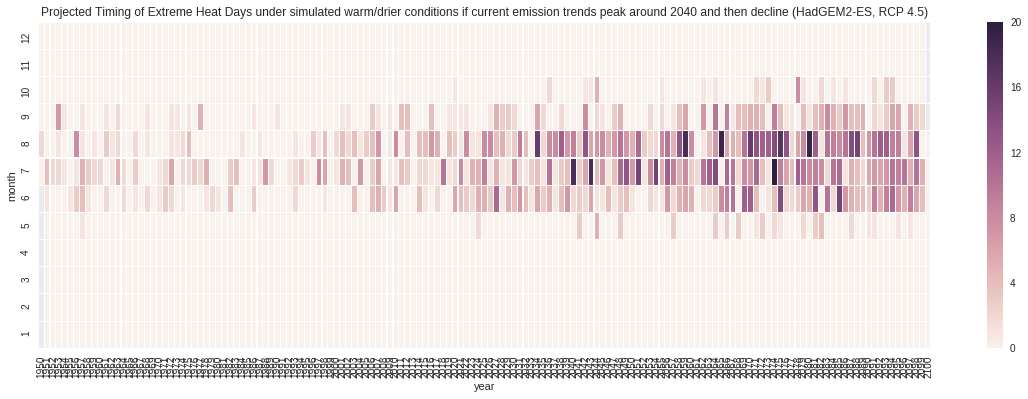

In [49]:
plt.figure(figsize=(20,6))
ax = sns.heatmap(hotdry, linewidth=0.1)
plt.title("Projected Timing of Extreme Heat Days under simulated warm/drier conditions if current emission trends peak around 2040 and then decline (HadGEM2-ES, RCP 4.5)")
plt.show()

### 2e. Extreme Heat Days by Decade

In [141]:
hcounts.resample('10AS').agg(['min', 'mean', 'max'])

,min,mean,max
1950-01-01,0,3.7,13
1960-01-01,0,3.1,12
1970-01-01,1,3.6,7
1980-01-01,0,5.6,17
1990-01-01,0,6.0,15
2000-01-01,1,4.1,8
2010-01-01,0,2.0,6


In [50]:
projcounts.resample('10AS').agg(['min', 'mean', 'max'])

CanESM2_rcp45           CNRM-CM5_rcp45           HadGEM2-ES_rcp45  \
                     min  mean max            min  mean max              min   
1950-01-01             1   3.4   7              0   3.7  10              1.0   
1960-01-01             3   5.2   8              0   4.0  13              0.0   
1970-01-01             0   4.3  10              0   4.7  10              1.0   
1980-01-01             0   3.3  16              1   5.3  11              0.0   
1990-01-01             1   4.4  10              0   6.5  17              0.0   
2000-01-01             4   8.0  14              3   8.2  16              3.0   
2010-01-01             3   9.0  21              0   6.9  13              0.0   
2020-01-01             7  15.1  23              4   7.7  12              8.0   
2030-01-01             9  19.1  31              1  11.3  29              4.0   
2040-01-01             7  19.3  38              4  10.7  19             10.0   
2050-01-01             9  22.4  37              8  12.6  20              5.0   
2060-01-01            13  22.3  35              9  13.3  22              2.0   
2070-01-01            16  25.5  41             10  20.1  31              9.0   
2080-01-01            15  20.4  32              4  15.2  27             15.0   
2090-01-01            15  21.5  32              9  18.6  37             14.0   
2100-01-01            16  16.0  16             15  15.0  15              NaN   

                       MIROC5_rcp45              
            mean   max          min  mean   max  
1950-01-01   5.2  12.0          0.0   5.1  13.0  
1960-01-01   3.3   9.0          0.0   4.0  11.0  
1970-01-01   5.2  11.0          0.0   4.4   9.0  
1980-01-01   2.8   7.0          0.0   4.6  15.0  
1990-01-01   3.4  10.0          0.0   6.2  24.0  
2000-01-01   8.0  16.0          0.0  10.8  24.0  
2010-01-01   8.5  15.0          0.0   7.4  16.0  
2020-01-01  14.2  25.0          0.0  12.4  25.0  
2030-01-01  16.2  32.0          1.0  15.8  41.0  
2040-01-01  22.1  33.0          1.0  15.0  33.0  
2050-01-01  20.1  35.0          4.0  18.5  31.0  
2060-01-01  23.0  36.0          2.0  12.6  35.0  
2070-01-01  29.9  48.0         15.0  24.4  36.0  
2080-01-01  28.4  40.0          9.0  28.6  53.0  
2090-01-01  26.0  38.0          5.0  22.3  40.0  
2100-01-01   NaN   NaN          NaN   NaN   NaN

In [53]:
deca = projcounts.resample('10AS').mean()
hcounts.name = 'livneh'
deca = deca.join(hcounts.resample('10AS').mean())
deca = deca.stack()
deca.index.names = ['decade', 'series']
deca.name = 'mean'
deca = deca.reset_index()

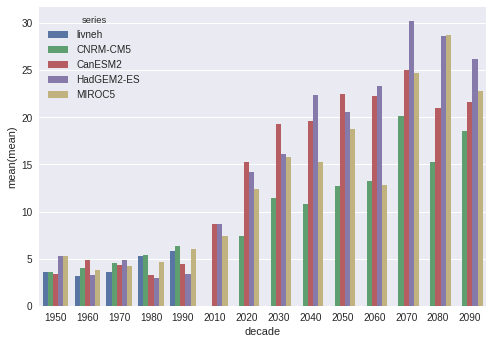

In [54]:
ax = sns.barplot(x='decade', y='mean', hue='series', data=deca)

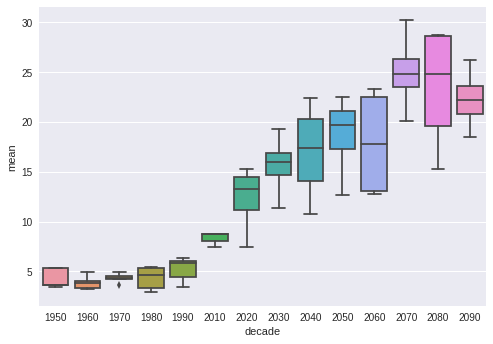

In [55]:
ax = sns.boxplot(x='decade', y='mean', data=deca)

----
## Step 3. Heat Waves
----

### Request heat waves

Use the `duration` parameter to define a heat wave length in number of days. We use four as the default definition.

In [153]:
params.update(duration=4, freq='A')
nwaves = fetch_exheat(climvar, period, models, scenarios, **params)
nwaves.columns = nwaves.columns.str.replace('tasmax_day_', '')
obsnwaves = fetch_exheat(climvar, period, ['livneh'], **params)
obsnwaves.columns = obsnwaves.columns.str.replace('tasmax_day_', '')
nwaves = nwaves.join(obsnwaves, how='outer')
nwaves.tail()

Processing: tasmax_day_CanESM2_rcp45
Processing: tasmax_day_CNRM-CM5_rcp45
Processing: tasmax_day_HadGEM2-ES_rcp45
Processing: tasmax_day_MIROC5_rcp45
Processing: tasmax_day_livneh


,CanESM2_rcp45,CNRM-CM5_rcp45,HadGEM2-ES_rcp45,MIROC5_rcp45,livneh
2096-12-31,2.0,2.0,1.0,7.0,NaN
2097-12-31,2.0,1.0,4.0,0.0,NaN
2098-12-31,5.0,1.0,5.0,2.0,NaN
2099-12-31,2.0,2.0,1.0,0.0,NaN
2100-12-31,1.0,1.0,NaN,NaN,NaN


In [154]:
# Pivot from columns to rows for plotting.
heat_waves = nwaves.unstack().reset_index()
heat_waves.columns = ['series', 'year', 'count']

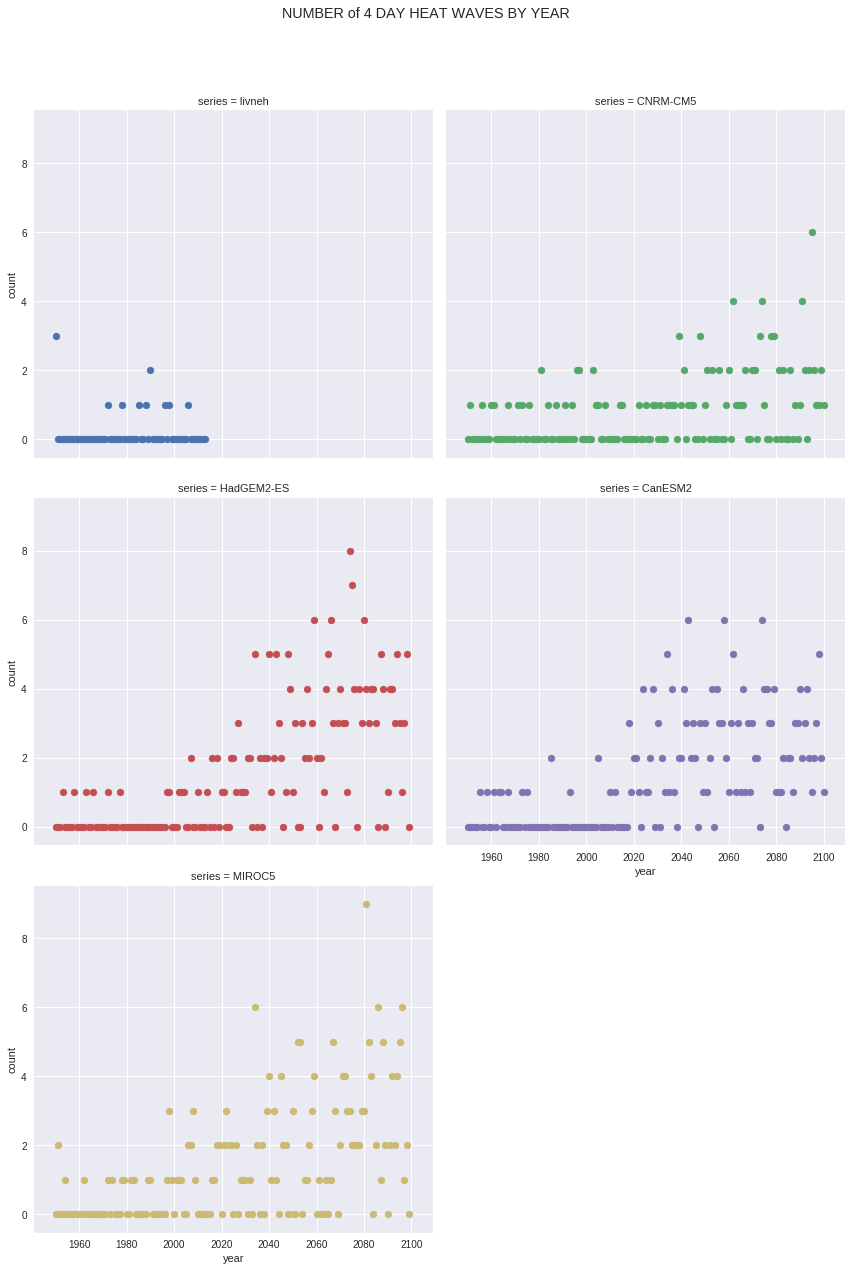

In [59]:
g = sns.FacetGrid(data=heat_waves, col='series', col_wrap=2, hue='series', size=6)
g.map(plt.scatter, 'year', 'count')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('NUMBER of 4 DAY HEAT WAVES BY YEAR')

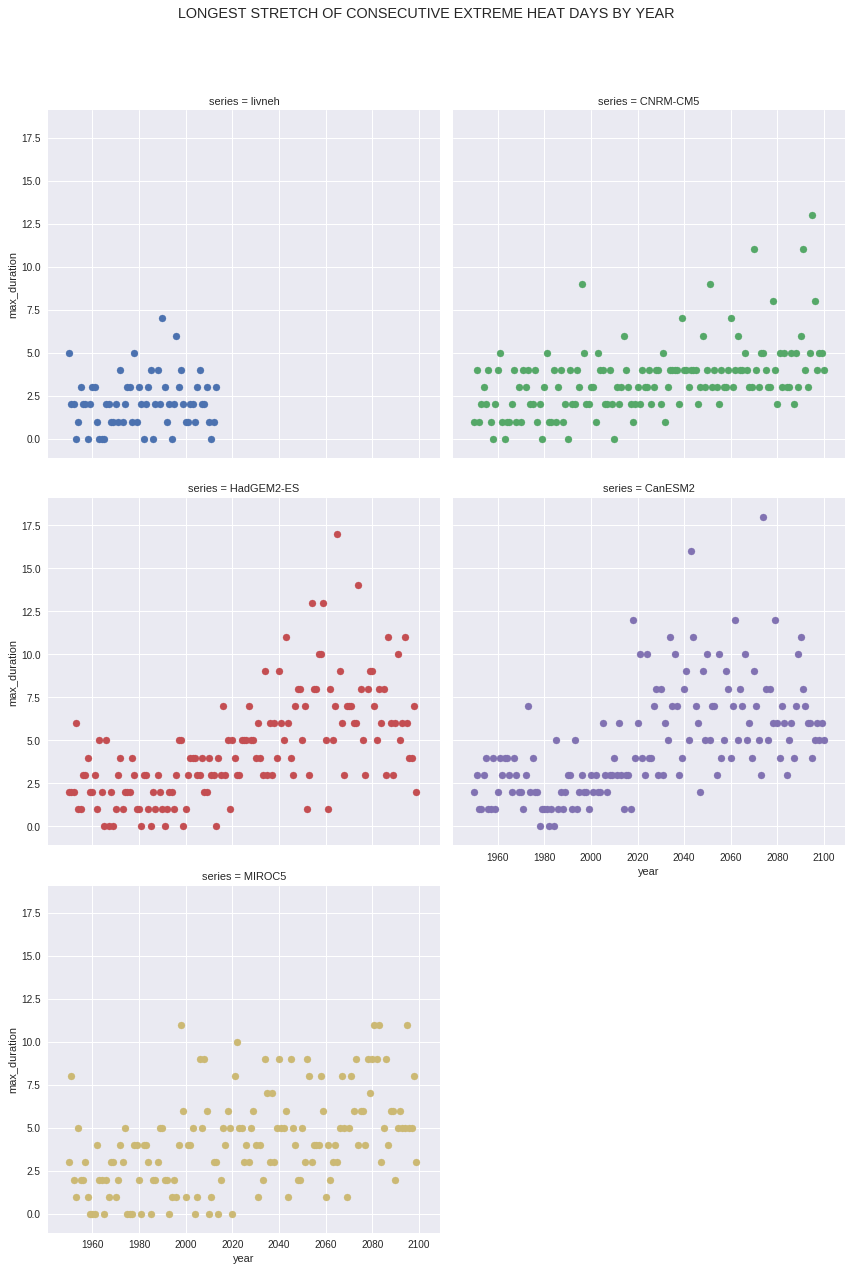

In [60]:
g = sns.FacetGrid(data=heat_waves, col='series', col_wrap=2, hue='series', size=6)
g.map(plt.scatter, 'year', 'max_duration')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('LONGEST STRETCH OF CONSECUTIVE EXTREME HEAT DAYS BY YEAR')